### Investigation on pruning

Here we will take a copy of the old notebook and prune it.

***First we will take all functions and stuff from before back here***

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split        #split data for training and testing
from sklearn.metrics import accuracy_score                  #to view accuracy
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.python.ops import array_ops, math_ops      #for math operations division_no_nan
from tensorflow.keras.layers import *
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from sklearn.metrics import roc_curve, auc
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

from qkeras import *
import hls4ml
from hls4ml.model.profiling import numerical, activations_keras, boxplot

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams['font.size'] = 16.0

seed = 48

np.random.seed(seed)
tf.random.set_seed(seed)

import os
import sys

# will need to clone https://github.com/kpidgeon/cms-l1-triggers for a few
# helper functions if running notebook and include path to repo here
sys.path.append('/usersc/bz18310/previous_notebook/cms-l1-triggers')

from utils.analysis import eff_rate, optimal_eff_rate
from utils.preprocessing import resize
from utils.plotting import *
from utils.hls4ml_helpers import *

plt.rc('figure', figsize=(8,6))


###for loading and saving models
from tensorflow.keras.models import load_model

from qkeras.utils import model_save_quantized_weights
from qkeras.utils import load_qmodel

###For Pruning summaries

import tempfile

In [2]:
# a couple of helper functions

push = lambda x: x > .5       #function to check if number greater than .5

def hls_model_accuracy(hls_model, test_X, test_y):                              #function for testing accurcry of hls model
    return accuracy_score(test_y, [push(i) for i in hls_model.predict(test_X)])


def get_timing(build_result):
    return (build_result['BestLatency'], build_result['WorstLatency'],
            build_result['IntervalMin'], build_result['IntervalMax'])


class CustomSensitivityAtSpecificity(tf.keras.metrics.SensitivityAtSpecificity):     #specificity TN/(TN+FP) 
                                                                                
    def __init__(self, specificity, num_thresholds=200, name=None, dtype=None):
        if specificity < 0 or specificity > 1:
            raise ValueError('`specificity` must be in the range [0, 1].')
        self.specificity = specificity
        self.num_thresholds = num_thresholds
        super().__init__(
            specificity, num_thresholds=num_thresholds, name=name, dtype=dtype)  #from the tf.kera.metrics.SensitivityAtSpecificity
                                                                                 #class, creates out object
    def result(self):
        specificities = math_ops.div_no_nan(
        self.true_negatives, self.true_negatives + self.false_positives)   #from keras class super()
        sensitivities = math_ops.div_no_nan(
        self.true_positives, self.true_positives + self.false_negatives)   
        return self._find_max_under_constraint(
                    specificities, sensitivities, math_ops.greater_equal)  #What?

    def get_threshold(self):
        specificities = math_ops.div_no_nan(
        self.true_negatives, self.true_negatives + self.false_positives)
        
        sensitivities = math_ops.div_no_nan(
        self.true_positives, self.true_positives + self.false_negatives)    #Sensitivity TP/(TP+FN)
        
        specs_above_thresh = array_ops.where(math_ops.greater_equal(specificities, self.value))   #What?
        
        return math_ops.reduce_min(array_ops.gather(self.thresholds, specs_above_thresh)).numpy()
        
    
    def get_config(self):
        config = {
            'num_thresholds': self.num_thresholds,
            'specificity': self.specificity
        }
        base_config = super().get_config()    #from keras class object.
        return dict(list(base_config.items()) + list(config.items()))
    

    
def trainer(model_name, train, savename, stripping):   #function for training and saving models
    if train:
        opt = tf.keras.optimizers.Adam(0.001)
        log_dir = tempfile.mkdtemp()
        sensitivity_metric = tf.keras.metrics.SensitivityAtSpecificity(name='sens_at_spec',
                                                                                 specificity=0.99925,     
                                                                                 num_thresholds=20000)     
        auc_metric = tf.keras.metrics.AUC(name='auc', num_thresholds=200)   
        metrics = ['accuracy', sensitivity_metric, auc_metric]

        model_name.compile(optimizer=opt, loss='binary_crossentropy', metrics=metrics)    

        model_name.fit(train_X, 
                   train_y, 
                   epochs=50, 
                   verbose=1,
                   batch_size=512, 
                   validation_split=.2,   
                   shuffle=True,
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                 patience=5,
                                                                 restore_best_weights=True),     #What does callbacks do?
                                pruning_callbacks.UpdatePruningStep(),
                                tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)])
            # Save the model again but with the pruning 'stripped' to use the regular layer types
        if stripping:
            model_stripped = strip_pruning(model_name)
            model_stripped.save(savename)
        else:
            model_name.save(savename)
    else:
        model_name = load_model(savename)

def show_weight_distrib(model_name):
    w = model_name.layers[0].weights[0].numpy()
    h, b = np.histogram(w, bins=100)
    plt.figure(figsize=(7,7))
    plt.bar(b[:-1], h, width=b[1]-b[0])
    plt.semilogy()
    plt.show()
    print('% of zeros = {}'.format(np.sum(w==0)/np.size(w)))

def sense_at_spec_scan(model_list, model_name_list):
    table = pd.DataFrame({'sens_at_spec_10kHz': [],
                                  'sens_at_spec_30kHz': [],
                                  'sens_at_spec_50kHz': [],
                                  'threshold_10kHz': [],
                                 'threshold_30kHz': [],
                                 'threshold_50kHz': []})
    
    sens_at_spec_30 = CustomSensitivityAtSpecificity(0.99925, num_thresholds=2000)    
    sens_at_spec_50 = CustomSensitivityAtSpecificity(0.99875, num_thresholds=2000)
    sens_at_spec_10 = CustomSensitivityAtSpecificity(0.99975, num_thresholds=2000)
    
    for i,m in enumerate(model_list):
        sens_at_spec_10.update_state(test_y, m.predict(test_X))   
        sens_at_spec_30.update_state(test_y, m.predict(test_X))
        sens_at_spec_50.update_state(test_y, m.predict(test_X))
        
        table = table.append({ 'sens_at_spec_10kHz': sens_at_spec_10.result().numpy(), #from class functions
                              'sens_at_spec_30kHz': sens_at_spec_30.result().numpy(),
                              'sens_at_spec_50kHz': sens_at_spec_50.result().numpy(),
                            'threshold_10kHz': sens_at_spec_10.get_threshold(),
                              'threshold_30kHz': sens_at_spec_30.get_threshold(),
                              'threshold_50kHz': sens_at_spec_50.get_threshold(),
                                  'model': model_name_list[i]
                             },
                             ignore_index=True)
    display(table)
    
def plot_roc_and_eff(model_list, model_name_list):
    bg_rate = 40*10**6
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots(figsize=(6,6))
    for i,m in enumerate(model_list):
        fpr, tpr, thresholds = roc_curve(test_y, m.predict(test_X))
        
        rates, rates_errs, effs, effs_errs = eff_rate(fpr, tpr, thresholds, 
                                                      bg_rate, 
                                                      test_y, 
                                                      m.predict(test_X))
        effs, rates, effs_errs, rates_errs = optimal_eff_rate(effs, rates, effs_errs, rates_errs)
        
        plot_roc(ax1, fpr, tpr, legend=True, label=model_name_list[i], lw=3.)
        plot_eff_rate(ax2, np.array(effs), np.array(rates), 
                      rates_errs=rates_errs, effs_errs=effs_errs, ls='', capsize=4., legend=True, label=model_name_list[i])
    
    ax1.plot([0,1], [0,1], ls='--', lw=2., color='black')
    ax1.set_yscale('log')
    ax1.set_ylim(0.000000001, 10)
    ax1.set_xscale('log')
    ax1.set_xlim(0.000000001, 10)
    
    ax2.set_xscale('log')
    ax2.set_xlim((1,1000))
    
    
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            # ignore auxiliary quantization weights
            if "quantize_layer" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )

#### Load the model here

In [3]:
data = np.load('./data_hh4b_20x12_160000.npz')
train_X = data['train_X']      #data for training the quantized model
train_y = data['train_y']      #data labels
test_X = data['test_X']
test_y = data['test_y']
test_X_hw_hh4b = data['test_X_hw_hh4b']
test_y_hw_hh4b = data['test_y_hw_hh4b']
test_X_hw_snu = data['test_X_hw_snu']
test_y_hw_snu = data['test_y_hw_snu']
data = 0

model = tf.keras.models.load_model('./cnn_20x12_keras_trained')   #load trained model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 18, 10, 4)         36        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 5, 4)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 5, 4)           16        
_________________________________________________________________
relu_c1 (Activation)         (None, 9, 5, 4)           0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 3, 8)           288       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 1, 8)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 1, 8)           3

Choose pruning parameters

pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75,             #75% sparse
                                                                         begin_step=2000,  #what?
                                                                         frequency=100)}
pmodel = prune.prune_low_magnitude(model, **pruning_params)  # pruned model

Compile and train model before pruning

In [4]:
trainer(model, train=True, savename='pruning_models/unpruned_train_1_test.h5', stripping=False)

Epoch 1/50
188/188 [==============================] - 13s 62ms/step - loss: 0.0789 - accuracy: 0.9733 - sens_at_spec: 0.6515 - auc: 0.9953 - val_loss: 0.0796 - val_accuracy: 0.9720 - val_sens_at_spec: 0.6248 - val_auc: 0.9955
Epoch 2/50
188/188 [==============================] - 11s 59ms/step - loss: 0.0791 - accuracy: 0.9727 - sens_at_spec: 0.6373 - auc: 0.9952 - val_loss: 0.0800 - val_accuracy: 0.9722 - val_sens_at_spec: 0.6271 - val_auc: 0.9953
Epoch 3/50
188/188 [==============================] - 11s 59ms/step - loss: 0.0792 - accuracy: 0.9724 - sens_at_spec: 0.6529 - auc: 0.9952 - val_loss: 0.0805 - val_accuracy: 0.9714 - val_sens_at_spec: 0.6547 - val_auc: 0.9954
Epoch 4/50
188/188 [==============================] - 11s 59ms/step - loss: 0.0794 - accuracy: 0.9729 - sens_at_spec: 0.6354 - auc: 0.9951 - val_loss: 0.0788 - val_accuracy: 0.9722 - val_sens_at_spec: 0.6510 - val_auc: 0.9955
Epoch 5/50
188/188 [==============================] - 11s 60ms/step - loss: 0.0789 - accuracy: 0

Visualise weights here.

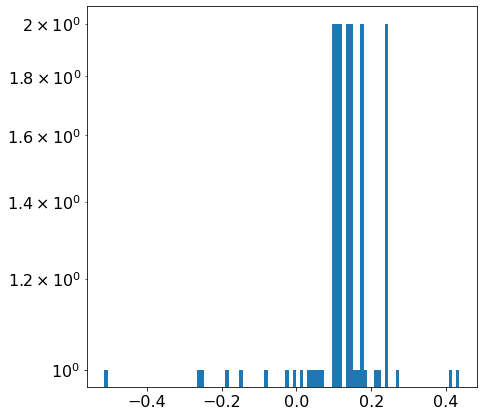

% of zeros = 0.0


In [5]:
show_weight_distrib(model)

In [6]:
model_for_pruning = tf.keras.models.load_model('./cnn_20x12_keras_trained')   #load trained model
model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model_for_pruning)

/software/bz18310/miniconda/envs/test_python_3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [7]:
trainer(model_for_pruning, train=True, savename='pruning_models/pruned_train_1_test.h5', stripping=True)

Epoch 1/50
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
188/188 [==============================] - 15s 64ms/step - loss: 0.0822 - accuracy: 0.9724 - sens_at_spec: 0.5522 - auc: 0.9947 - val_loss: 0.0894 - val_accuracy: 0.9683 - val_sens_at_spec: 0.5210 - val_auc: 0.9948
Epoch 2/50
188/188 [==============================] - 11s 59ms/step - loss: 0.0839 - accuracy: 0.9714 - sens_at_spec: 0.4993 - auc: 0.9945 - val_loss: 0.0825 - val_accuracy: 0.9703 - val_sens_at_spec: 0.5819 - val_auc: 0.9950
Epoch 3/50
188/188 [==============================] - 12s 61ms/step - loss: 0.0831 - accuracy: 0.9719 - sens_at_spec: 0.5281 - auc: 0.9946 - val_loss: 0.0822 - val_accuracy: 0.9710 - val_sens_at_spec: 0.5795 - val_auc: 0.9951
Epoch 4/50
188/188 [==============================] - 11s 61ms/step - loss: 0.0828 - accuracy: 0.9721 - sens_at_spec: 0.5422 - auc: 0.9947 - val_loss: 0.0817 - val_accuracy: 0.9707 - v

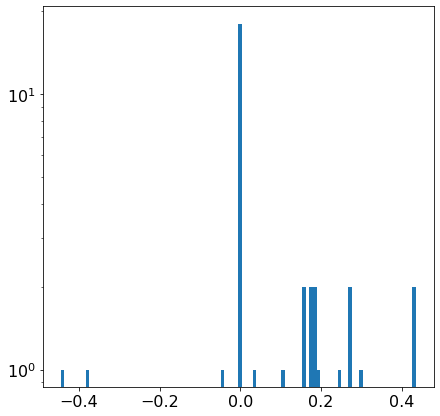

% of zeros = 0.5


In [8]:
show_weight_distrib(model_for_pruning)

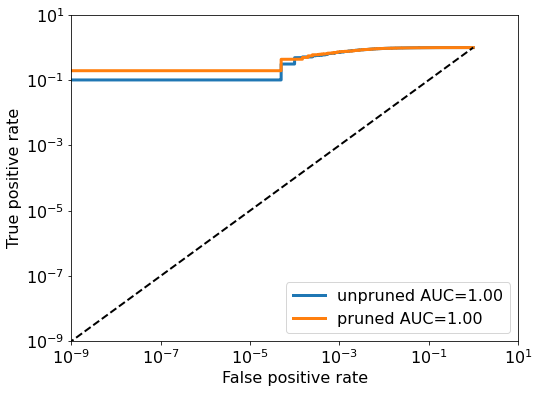

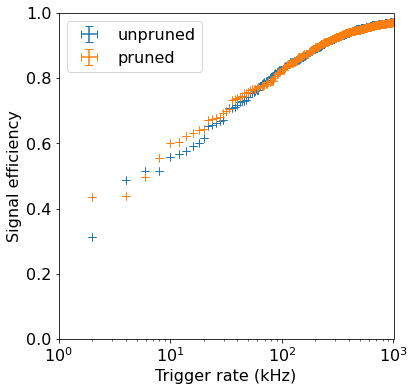

In [9]:
plot_roc_and_eff([model, model_for_pruning], ['unpruned', 'pruned'])

In [10]:
sense_at_spec_scan([model, model_for_pruning], ['unpruned', 'pruned'])

,sens_at_spec_10kHz,sens_at_spec_30kHz,sens_at_spec_50kHz,threshold_10kHz,threshold_30kHz,threshold_50kHz,model
0,0.532660,0.655010,0.738519,0.996998,0.994998,0.991996,unpruned
1,0.525676,0.688247,0.749824,0.996998,0.993497,0.989995,pruned


In [11]:
print('Unpruned model evaluation: \n')
model.evaluate(test_X, test_y)
print('\nPruned model evaluation: \n')
model_for_pruning.evaluate(test_X, test_y)

Unpruned model evaluation: 

1250/1250 [==============================] - 4s 3ms/step - loss: 0.0759 - accuracy: 0.9735 - sens_at_spec: 0.6696 - auc: 0.9957

Pruned model evaluation: 

1250/1250 [==============================] - 5s 3ms/step - loss: 0.0766 - accuracy: 0.9730 - sens_at_spec: 0.6924 - auc: 0.9957


[0.07656493037939072,
 0.9730499982833862,
 0.6923927068710327,
 0.9956637620925903]

### Now Pruning on the QAT models.

In [12]:
b = 5
config = {

        'QConv2D': {
          "kernel_quantizer": f'quantized_bits({b})',
          "bias_quantizer": f'quantized_bits({b})'
        },
        'QDense': {
          "kernel_quantizer": f'quantized_bits({b})',
          "bias_quantizer": f'quantized_bits({b})'
        },
        'QActivation': {'relu': f'quantized_relu({b})'}

    }

model_for_quantization = tf.keras.models.load_model('./cnn_20x12_keras_trained')
qmodel = utils.model_quantize(model_for_quantization, config, b)
qmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (QConv2D)              (None, 18, 10, 4)         36        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 5, 4)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 5, 4)           16        
_________________________________________________________________
relu_c1 (QActivation)        (None, 9, 5, 4)           0         
_________________________________________________________________
conv2 (QConv2D)              (None, 7, 3, 8)           288       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 1, 8)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 1, 8)           3

In [13]:
trainer(qmodel, train=True, savename='pruning_models/qmodel_unpruned_train_1_test.h5', stripping=False)

Epoch 1/50
188/188 [==============================] - 16s 71ms/step - loss: 0.3294 - accuracy: 0.9582 - sens_at_spec: 0.0972 - auc: 0.9862 - val_loss: 0.6543 - val_accuracy: 0.5560 - val_sens_at_spec: 0.4172 - val_auc: 0.9879
Epoch 2/50
188/188 [==============================] - 12s 62ms/step - loss: 0.2808 - accuracy: 0.9672 - sens_at_spec: 0.1475 - auc: 0.9899 - val_loss: 0.4038 - val_accuracy: 0.8430 - val_sens_at_spec: 0.4313 - val_auc: 0.9938
Epoch 3/50
188/188 [==============================] - 12s 63ms/step - loss: 0.2481 - accuracy: 0.9688 - sens_at_spec: 0.1985 - auc: 0.9909 - val_loss: 0.2473 - val_accuracy: 0.9650 - val_sens_at_spec: 0.3076 - val_auc: 0.9942
Epoch 4/50
188/188 [==============================] - 12s 63ms/step - loss: 0.2223 - accuracy: 0.9698 - sens_at_spec: 0.1790 - auc: 0.9914 - val_loss: 0.2083 - val_accuracy: 0.9700 - val_sens_at_spec: 0.2655 - val_auc: 0.9934
Epoch 5/50
188/188 [==============================] - 12s 64ms/step - loss: 0.2011 - accuracy: 0

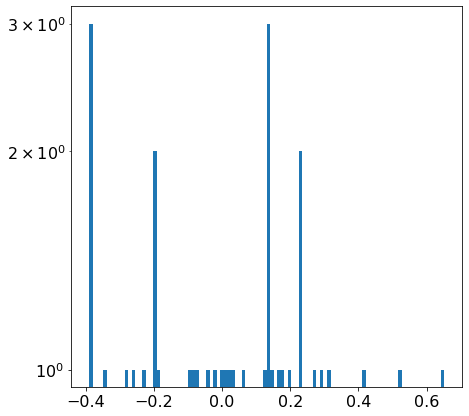

% of zeros = 0.0


In [14]:
show_weight_distrib(qmodel)

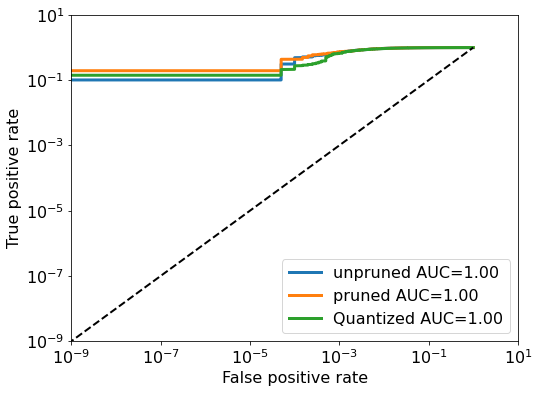

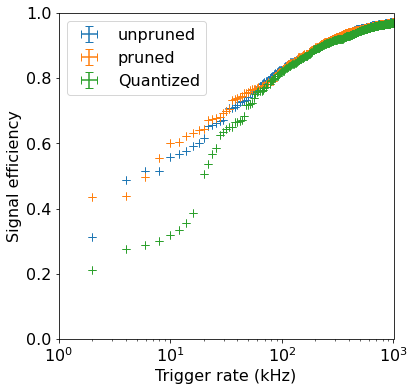

In [15]:
plot_roc_and_eff([model, model_for_pruning, qmodel], ['unpruned', 'pruned', 'Quantized'])

***Prune the quantized model***

In [16]:
#qmodel_for_pruning = load_qmodel('./pruning_models/qmodel_unpruned_train_1_test.h5')

#qmodel_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(qmodel_for_pruning)

In [17]:
#trainer(qmodel_for_pruning, train=True, savename='pruning_models/qmodel_pruned_train_1_test.h5', stripping=True)

In [18]:
#show_weight_distrib(qmodel_for_pruning)

In [19]:
#plot_roc_and_eff([model, model_for_pruning, qmodel, qmodel_for_pruning], ['unpruned', 'pruned', 'Quantized', 'Quantized Pruned'])

### Now do it in HLS and look at the perfomance of the model

Compile the hls4ml models

In [20]:
def hls4ml_converter_quantized(model_list, converted_dir):   #not sure ill use this...
    for i,m in enumerate(model_list):
        hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']      #What does this do?
        hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
        hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

        config = hls4ml.utils.config_from_keras_model(m, granularity='name')   #hls4ml get config from kera config
        for l in config['LayerName']:
            config['LayerName'][l]['Strategy'] = 'Latency'
        config['LayerName']['sigmoid']['exp_table_t'] = 'ap_fixed<18,8>'
        config['LayerName']['sigmoid']['inv_table_t'] = 'ap_fixed<18,4>'

        hls_model = hls4ml.converters.convert_from_keras_model(m,
                                                           hls_config=config,   #set configuration of model
                                                           output_dir=converter_dir[i],  #6bit model save
                                                           fpga_part='xcku15p-ffva1760-2-e',     #What?
                                                            clock_period=(1/.24),      #set clock period??
                                                              io_type='io_stream')     #What?
        hls_model.compile()   #compiles model
        

def hls4ml_converter(model_name, directory, stripping):
    if stripping:
        model_name = strip_pruning(model_name)
        
    config = hls4ml.utils.config_from_keras_model(model_name, granularity='name')
    print("-----------------------------------")
    print("Configuration")
    display(config)
    print("-----------------------------------")
    hls_model = hls4ml.converters.convert_from_keras_model(model_name,
                                                           hls_config=config,   #set configuration of model
                                                           output_dir=directory,  #6bit model save
                                                           fpga_part='xcku15p-ffva1760-2-e',     #What?
                                                            clock_period=(1/.24),      #set clock period??
                                                              io_type='io_stream')     #
    hls_model.compile()
    return hls_model


In [21]:
hls4ml_unpruned = hls4ml_converter(model, 'pruning_models/hls_unpruned/hls4ml_prj', stripping=False)
hls4ml_pruned = hls4ml_converter(model_for_pruning, 'pruning_models/hls_pruned/hls4ml_prj', stripping=True)

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: Input
Layer name: conv1, layer type: Conv2D
  -> Activation (linear), layer name: conv1
Layer name: max_pooling2d, layer type: MaxPooling2D
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: relu_c1, layer type: Activation
Layer name: conv2, layer type: Conv2D
  -> Activation (linear), layer name: conv2
Layer name: max_pooling2d_1, layer type: MaxPooling2D
Layer name: batch_normalization_1, layer type: BatchNormalization
Layer name: relu_c2, layer type: Activation
Layer name: dense1, layer type: Dense
  -> Activation (linear), layer name: dense1
Layer name: batch_normalization_2, layer type: BatchNormalization
Layer name: relu1, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: batch_normalization_3, layer type: BatchNormalization
Layer name: sigmoid, layer type: Activation
-----------------------------------
Configuration


{'Model': {'Precision': 'ap_fixed<16,6>',
  'ReuseFactor': 1,
  'Strategy': 'Latency'},
 'LayerName': {'conv1_input': {'Precision': {'result': 'ap_fixed<16,6>'}},
  'conv1': {'Precision': {'weight': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>',
    'result': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'conv1_linear': {'Precision': 'ap_fixed<16,6>',
   'ReuseFactor': 1,
   'table_size': 1024,
   'table_t': 'ap_fixed<18,8>'},
  'max_pooling2d': {'Precision': 'ap_fixed<16,6>'},
  'batch_normalization': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'relu_c1': {'Precision': 'ap_fixed<16,6>',
   'ReuseFactor': 1,
   'table_size': 1024,
   'table_t': 'ap_fixed<18,8>'},
  'conv2': {'Precision': {'weight': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>',
    'result': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'conv2_linear': {'Precision': 'ap_fixed<16,6>',
   'ReuseFactor': 1,
   'table_size': 1024,
   'table_t': 'ap_fixed<18,8>'},
  'max_pool

-----------------------------------
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: conv1, layer type: Conv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Layer name: relu_c1, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: conv2, layer type: Conv2D, current shape: [[None, 9, 5, 4]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 7, 3, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 3, 1, 8]]
Layer name: relu_c2, layer type: Activation, current shape: [[None, 3, 1, 8]]
Layer name: dense1, layer type: Dense, current shape: [[None, 3, 1, 8]]
Layer name: batch_normalization_2, layer type: BatchNormalization, current shape: [[None, 24]]
Lay

{'Model': {'Precision': 'ap_fixed<16,6>',
  'ReuseFactor': 1,
  'Strategy': 'Latency'},
 'LayerName': {'conv1_input': {'Precision': {'result': 'ap_fixed<16,6>'}},
  'conv1': {'Precision': {'weight': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>',
    'result': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'conv1_linear': {'Precision': 'ap_fixed<16,6>',
   'ReuseFactor': 1,
   'table_size': 1024,
   'table_t': 'ap_fixed<18,8>'},
  'max_pooling2d': {'Precision': 'ap_fixed<16,6>'},
  'batch_normalization': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'relu_c1': {'Precision': 'ap_fixed<16,6>',
   'ReuseFactor': 1,
   'table_size': 1024,
   'table_t': 'ap_fixed<18,8>'},
  'conv2': {'Precision': {'weight': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>',
    'result': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'conv2_linear': {'Precision': 'ap_fixed<16,6>',
   'ReuseFactor': 1,
   'table_size': 1024,
   'table_t': 'ap_fixed<18,8>'},
  'max_pool

-----------------------------------
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: conv1, layer type: Conv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Layer name: relu_c1, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: conv2, layer type: Conv2D, current shape: [[None, 9, 5, 4]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 7, 3, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 3, 1, 8]]
Layer name: relu_c2, layer type: Activation, current shape: [[None, 3, 1, 8]]
Layer name: dense1, layer type: Dense, current shape: [[None, 3, 1, 8]]
Layer name: batch_normalization_2, layer type: BatchNormalization, current shape: [[None, 24]]
Lay

Done


In [22]:
hls4ml.utils.plot_model(hls4ml_unpruned, show_shapes=True, show_precision=True, to_file=None)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


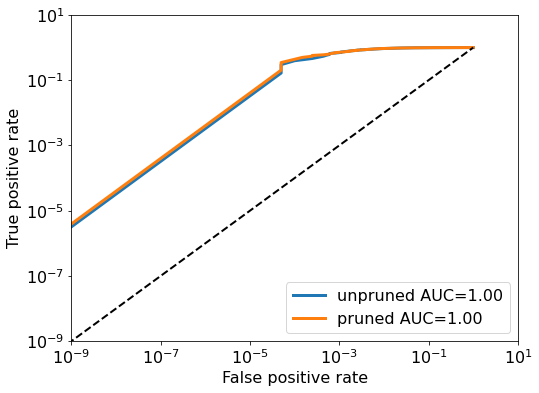

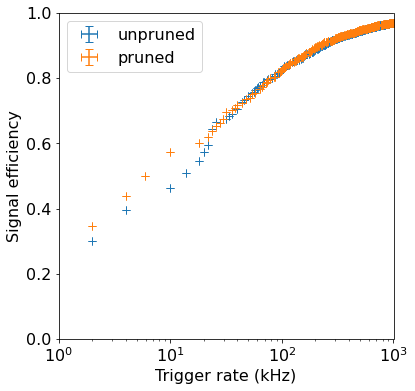

In [23]:
plot_roc_and_eff([hls4ml_unpruned, hls4ml_pruned], ['unpruned', 'pruned'])

In [24]:
sense_at_spec_scan([hls4ml_unpruned, hls4ml_pruned], ['unpruned', 'pruned'])

,sens_at_spec_10kHz,sens_at_spec_30kHz,sens_at_spec_50kHz,threshold_10kHz,threshold_30kHz,threshold_50kHz,model
0,0.462667,0.666616,0.746056,0.995498,0.986493,0.973987,unpruned
1,0.481233,0.676615,0.741810,0.995498,0.986493,0.976988,pruned


In [25]:
hls4ml_unpruned.build(csim=False)
hls4ml_pruned.build(csim=False)

{'EstimatedClockPeriod': '3.646',
 'BestLatency': '280',
 'WorstLatency': '280',
 'IntervalMin': '247',
 'IntervalMax': '247',
 'BRAM_18K': '18',
 'DSP48E': '437',
 'FF': '11654',
 'LUT': '25480',
 'URAM': '0',
 'AvailableBRAM_18K': '1968',
 'AvailableDSP48E': '1968',
 'AvailableFF': '1045440',
 'AvailableLUT': '522720',
 'AvailableURAM': '128'}

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 18, 10, 4)         36        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 5, 4)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 5, 4)           16        
_________________________________________________________________
relu_c1 (Activation)         (None, 9, 5, 4)           0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 3, 8)           288       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 1, 8)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 1, 8)           3

In [27]:
hls4ml.report.read_vivado_report('pruning_models/hls_unpruned/hls4ml_prj')

Found 1 solution(s) in pruning_models/hls_unpruned/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sat Jul 24 13:25:02 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexuplus
* Target device:  xcku15p-ffva1760-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 4.17 ns | 3.646 ns |   0.52 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+----------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline |
    |   min   |   max   |    min   |    max   | min | max |   Type   |
    +---------+

In [28]:
hls4ml.report.read_vivado_report('pruning_models/hls_pruned/hls4ml_prj')

Found 1 solution(s) in pruning_models/hls_pruned/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sat Jul 24 13:27:22 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexuplus
* Target device:  xcku15p-ffva1760-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 4.17 ns | 3.646 ns |   0.52 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+----------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline |
    |   min   |   max   |    min   |    max   | min | max |   Type   |
    +---------+--

### Pruning Quantized aware trained model.

Can prune quentised model - prune sparse!

In [29]:
qmodel_for_pruning = load_qmodel('./pruning_models/qmodel_unpruned_train_1_test.h5')

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.5, begin_step=2000, frequency=100)}
qmodel_for_pruning = prune.prune_low_magnitude(qmodel_for_pruning, **pruning_params)

/software/bz18310/miniconda/envs/test_python_3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [30]:
qmodel_for_pruning.summary()
qmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv1 (P (None, 18, 10, 4)         74        
_________________________________________________________________
prune_low_magnitude_max_pool (None, 9, 5, 4)           1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 9, 5, 4)           17        
_________________________________________________________________
prune_low_magnitude_relu_c1  (None, 9, 5, 4)           1         
_________________________________________________________________
prune_low_magnitude_conv2 (P (None, 7, 3, 8)           578       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 3, 1, 8)           1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 3, 1, 8)           3

In [31]:
trainer(qmodel_for_pruning, train=True, savename='pruning_models/qmodel_pruned_train_1_test.h5', stripping=False)

Epoch 1/50
  6/188 [..............................] - ETA: 28s - loss: 0.0882 - accuracy: 0.9701 - sens_at_spec: 0.7588 - auc: 0.9952WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0639s vs `on_train_batch_end` time: 0.0792s). Check your callbacks.


188/188 [==============================] - 18s 72ms/step - loss: 0.0774 - accuracy: 0.9739 - sens_at_spec: 0.6513 - auc: 0.9954 - val_loss: 0.0867 - val_accuracy: 0.9697 - val_sens_at_spec: 0.5618 - val_auc: 0.9949
Epoch 2/50
188/188 [==============================] - 12s 63ms/step - loss: 0.0776 - accuracy: 0.9738 - sens_at_spec: 0.6135 - auc: 0.9953 - val_loss: 0.0903 - val_accuracy: 0.9685 - val_sens_at_spec: 0.5141 - val_auc: 0.9948
Epoch 3/50
188/188 [==============================] - 12s 63ms/step - loss: 0.0777 - accuracy: 0.9735 - sens_at_spec: 0.6253 - auc: 0.9953 - val_loss: 0.0921 - val_accuracy: 0.9679 - val_sens_at_spec: 0.4322 - val_auc: 0.9948
Epoch 4/50
188/188 [==============================] - 12s 63ms/step - loss: 0.0776 - accuracy: 0.9736 - sens_at_spec: 0.6086 - auc: 0.9952 - val_loss: 0.0853 - val_accuracy: 0.9711 - val_sens_at_spec: 0.5575 - val_auc: 0.9949
Epoch 5/50
188/188 [==============================] - 12s 64ms/step - loss: 0.0776 - accuracy: 0.9737 - sen

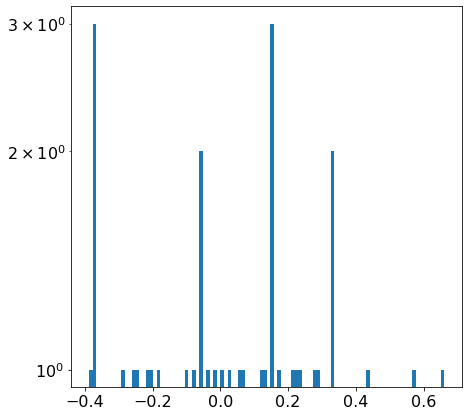

% of zeros = 0.0


In [32]:
show_weight_distrib(qmodel_for_pruning)

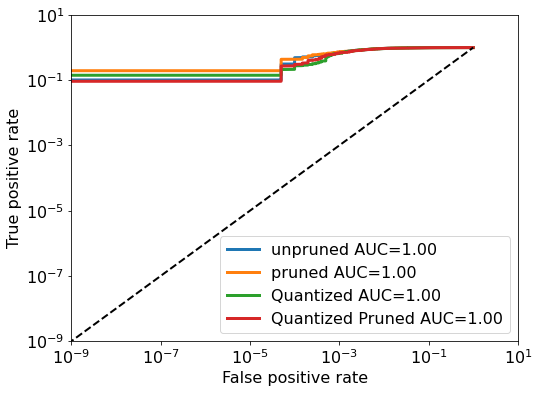

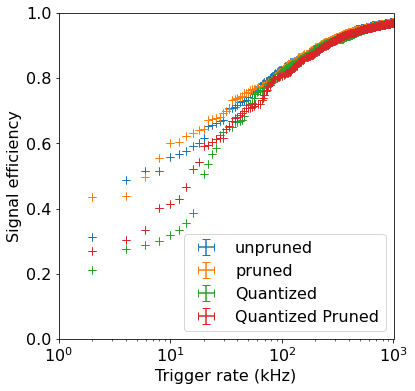

In [33]:
plot_roc_and_eff([model, model_for_pruning, qmodel, qmodel_for_pruning], ['unpruned', 'pruned', 'Quantized', 'Quantized Pruned'])

In [34]:
hls4ml_qmodel_unpruned = hls4ml_converter(qmodel, 'pruning_models/hls_qmodel_unpruned/hls4ml_prj', stripping=False)
hls4ml_qmodel_pruned = hls4ml_converter(qmodel_for_pruning, 'pruning_models/hls_qmodel_pruned/hls4ml_prj', stripping=True)

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: Input
Layer name: conv1, layer type: QConv2D
Layer name: max_pooling2d, layer type: MaxPooling2D
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: relu_c1, layer type: QActivation
Layer name: conv2, layer type: QConv2D
Layer name: max_pooling2d_1, layer type: MaxPooling2D
Layer name: batch_normalization_1, layer type: BatchNormalization
Layer name: relu_c2, layer type: QActivation
Layer name: dense1, layer type: QDense
Layer name: batch_normalization_2, layer type: BatchNormalization
Layer name: relu1, layer type: QActivation
Layer name: output, layer type: QDense
Layer name: batch_normalization_3, layer type: BatchNormalization
Layer name: sigmoid, layer type: Activation
-----------------------------------
Configuration


{'Model': {'Precision': 'ap_fixed<16,6>',
  'ReuseFactor': 1,
  'Strategy': 'Latency'},
 'LayerName': {'conv1_input': {'Precision': {'result': 'ap_fixed<16,6>'}},
  'conv1': {'Precision': {'weight': 'ap_fixed<6,1>'}, 'ReuseFactor': 1},
  'max_pooling2d': {'Precision': 'ap_fixed<16,6>'},
  'batch_normalization': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'relu_c1': {'Precision': {'result': 'ap_fixed<6,1>'}, 'ReuseFactor': 1},
  'conv2': {'Precision': {'weight': 'ap_fixed<6,1>'}, 'ReuseFactor': 1},
  'max_pooling2d_1': {'Precision': 'ap_fixed<16,6>'},
  'batch_normalization_1': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'relu_c2': {'Precision': {'result': 'ap_fixed<6,1>'}, 'ReuseFactor': 1},
  'dense1': {'Precision': {'weight': 'ap_fixed<6,1>'}, 'ReuseFactor': 1},
  'batch_normalization_2': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1

-----------------------------------
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: conv1, layer type: QConv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Name: quantized_relu
Layer name: relu_c1, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: conv2, layer type: QConv2D, current shape: [[None, 9, 5, 4]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 7, 3, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 3, 1, 8]]
Name: quantized_relu
Layer name: relu_c2, layer type: Activation, current shape: [[None, 3, 1, 8]]
Layer name: dense1, layer type: QDense, current shape: [[None, 3, 1, 8]]
Layer name: batch_normalization_2, layer type: BatchN

{'Model': {'Precision': 'ap_fixed<16,6>',
  'ReuseFactor': 1,
  'Strategy': 'Latency'},
 'LayerName': {'conv1_input': {'Precision': {'result': 'ap_fixed<16,6>'}},
  'conv1': {'Precision': {'weight': 'ap_fixed<6,1>'}, 'ReuseFactor': 1},
  'max_pooling2d': {'Precision': 'ap_fixed<16,6>'},
  'batch_normalization': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'relu_c1': {'Precision': {'result': 'ap_fixed<6,1>'}, 'ReuseFactor': 1},
  'conv2': {'Precision': {'weight': 'ap_fixed<6,1>'}, 'ReuseFactor': 1},
  'max_pooling2d_1': {'Precision': 'ap_fixed<16,6>'},
  'batch_normalization_1': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'relu_c2': {'Precision': {'result': 'ap_fixed<6,1>'}, 'ReuseFactor': 1},
  'dense1': {'Precision': {'weight': 'ap_fixed<6,1>'}, 'ReuseFactor': 1},
  'batch_normalization_2': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1

-----------------------------------
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: conv1, layer type: QConv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Name: quantized_relu
Layer name: relu_c1, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: conv2, layer type: QConv2D, current shape: [[None, 9, 5, 4]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 7, 3, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 3, 1, 8]]
Name: quantized_relu
Layer name: relu_c2, layer type: Activation, current shape: [[None, 3, 1, 8]]
Layer name: dense1, layer type: QDense, current shape: [[None, 3, 1, 8]]
Layer name: batch_normalization_2, layer type: BatchN

Done


In [35]:
hls4ml.utils.plot_model(hls4ml_qmodel_unpruned, show_shapes=True, show_precision=True, to_file=None)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [36]:
hls4ml_qmodel_unpruned.build(csim=False)
hls4ml_qmodel_pruned.build(csim=False)

{'EstimatedClockPeriod': '3.646',
 'BestLatency': '288',
 'WorstLatency': '288',
 'IntervalMin': '247',
 'IntervalMax': '247',
 'BRAM_18K': '18',
 'DSP48E': '14',
 'FF': '10780',
 'LUT': '40537',
 'URAM': '0',
 'AvailableBRAM_18K': '1968',
 'AvailableDSP48E': '1968',
 'AvailableFF': '1045440',
 'AvailableLUT': '522720',
 'AvailableURAM': '128'}

In [37]:
hls4ml.report.read_vivado_report('pruning_models/hls_qmodel_unpruned/hls4ml_prj')

Found 1 solution(s) in pruning_models/hls_qmodel_unpruned/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sat Jul 24 13:35:35 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexuplus
* Target device:  xcku15p-ffva1760-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 4.17 ns | 3.646 ns |   0.52 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+----------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline |
    |   min   |   max   |    min   |    max   | min | max |   Type   |
    +---

In [38]:
hls4ml.report.read_vivado_report('pruning_models/hls_qmodel_pruned/hls4ml_prj')

Found 1 solution(s) in pruning_models/hls_qmodel_pruned/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sat Jul 24 13:38:53 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexuplus
* Target device:  xcku15p-ffva1760-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 4.17 ns | 3.646 ns |   0.52 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+----------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline |
    |   min   |   max   |    min   |    max   | min | max |   Type   |
    +-----

### Higher level Pruning

Here add more pruning to pruned model.

In [39]:
model_for_pruning_075 = load_model('./pruning_models/unpruned_train_1_test.h5')

#from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
#from tensorflow_model_optimization.sparsity.keras import strip_pruning
#pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model_for_pruning_075 = prune.prune_low_magnitude(model_for_pruning_075)

model_for_pruning_075.summary()

/software/bz18310/miniconda/envs/test_python_3/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv1 (P (None, 18, 10, 4)         74        
_________________________________________________________________
prune_low_magnitude_max_pool (None, 9, 5, 4)           1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 9, 5, 4)           17        
_________________________________________________________________
prune_low_magnitude_relu_c1  (None, 9, 5, 4)           1         
_________________________________________________________________
prune_low_magnitude_conv2 (P (None, 7, 3, 8)           578       
_________________________________________________________________
prune_low_magnitude_max_pool (None, 3, 1, 8)           1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 3, 1, 8)           3

In [40]:
model_test = load_model('./pruning_models/unpruned_train_1_test.h5')




pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.75,
                                                               begin_step=0)
}

model_for_pruning_075 = tfmot.sparsity.keras.prune_low_magnitude(model_test, **pruning_params)

In [41]:
trainer(model_for_pruning_075, train=True, savename='pruning_models/pruned075_train_1_test.h5', stripping=True)

Epoch 1/50
188/188 [==============================] - 15s 67ms/step - loss: 0.1071 - accuracy: 0.9654 - sens_at_spec: 0.2910 - auc: 0.9917 - val_loss: 0.2560 - val_accuracy: 0.9070 - val_sens_at_spec: 0.4342 - val_auc: 0.9906
Epoch 2/50
188/188 [==============================] - 12s 62ms/step - loss: 0.0981 - accuracy: 0.9669 - sens_at_spec: 0.2733 - auc: 0.9928 - val_loss: 0.0949 - val_accuracy: 0.9675 - val_sens_at_spec: 0.3372 - val_auc: 0.9938
Epoch 3/50
188/188 [==============================] - 12s 61ms/step - loss: 0.0930 - accuracy: 0.9686 - sens_at_spec: 0.3443 - auc: 0.9934 - val_loss: 0.0899 - val_accuracy: 0.9695 - val_sens_at_spec: 0.3078 - val_auc: 0.9941
Epoch 4/50
188/188 [==============================] - 12s 61ms/step - loss: 0.0911 - accuracy: 0.9693 - sens_at_spec: 0.3813 - auc: 0.9936 - val_loss: 0.0886 - val_accuracy: 0.9697 - val_sens_at_spec: 0.3463 - val_auc: 0.9942
Epoch 5/50
188/188 [==============================] - 11s 60ms/step - loss: 0.0897 - accuracy: 0

In [42]:
print_model_weights_sparsity(model_for_pruning_075)

conv1/kernel:0: 75.00% sparsity  (27/36)
batch_normalization/gamma:0: 0.00% sparsity  (0/4)
batch_normalization/beta:0: 0.00% sparsity  (0/4)
conv2/kernel:0: 75.00% sparsity  (216/288)
batch_normalization_1/gamma:0: 0.00% sparsity  (0/8)
batch_normalization_1/beta:0: 0.00% sparsity  (0/8)
dense1/kernel:0: 75.00% sparsity  (432/576)
batch_normalization_2/gamma:0: 0.00% sparsity  (0/24)
batch_normalization_2/beta:0: 0.00% sparsity  (0/24)
output/kernel:0: 75.00% sparsity  (18/24)
output/bias:0: 0.00% sparsity  (0/1)
batch_normalization_3/gamma:0: 0.00% sparsity  (0/1)
batch_normalization_3/beta:0: 0.00% sparsity  (0/1)


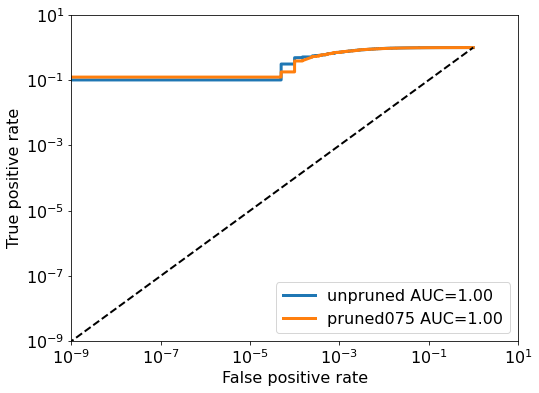

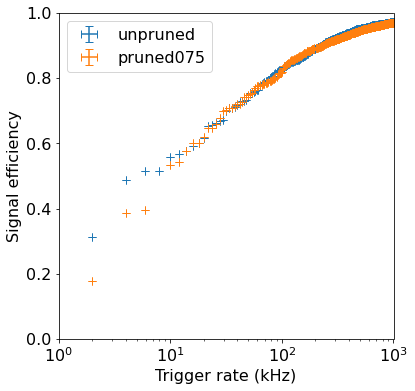

In [43]:
plot_roc_and_eff([model, model_for_pruning_075], ['unpruned', 'pruned075'])

In [44]:
hls4ml_model_pruned_075 = hls4ml_converter(model_for_pruning_075, 'pruning_models/hls_pruned_075/hls4ml_prj', stripping=True)

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: Input
Layer name: conv1, layer type: Conv2D
  -> Activation (linear), layer name: conv1
Layer name: max_pooling2d, layer type: MaxPooling2D
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: relu_c1, layer type: Activation
Layer name: conv2, layer type: Conv2D
  -> Activation (linear), layer name: conv2
Layer name: max_pooling2d_1, layer type: MaxPooling2D
Layer name: batch_normalization_1, layer type: BatchNormalization
Layer name: relu_c2, layer type: Activation
Layer name: dense1, layer type: Dense
  -> Activation (linear), layer name: dense1
Layer name: batch_normalization_2, layer type: BatchNormalization
Layer name: relu1, layer type: Activation
Layer name: output, layer type: Dense
  -> Activation (linear), layer name: output
Layer name: batch_normalization_3, layer type: BatchNormalization
Layer name: sigmoid, layer type: Activation
-----------------------------------
Configuration


{'Model': {'Precision': 'ap_fixed<16,6>',
  'ReuseFactor': 1,
  'Strategy': 'Latency'},
 'LayerName': {'conv1_input': {'Precision': {'result': 'ap_fixed<16,6>'}},
  'conv1': {'Precision': {'weight': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>',
    'result': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'conv1_linear': {'Precision': 'ap_fixed<16,6>',
   'ReuseFactor': 1,
   'table_size': 1024,
   'table_t': 'ap_fixed<18,8>'},
  'max_pooling2d': {'Precision': 'ap_fixed<16,6>'},
  'batch_normalization': {'Precision': {'scale': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'relu_c1': {'Precision': 'ap_fixed<16,6>',
   'ReuseFactor': 1,
   'table_size': 1024,
   'table_t': 'ap_fixed<18,8>'},
  'conv2': {'Precision': {'weight': 'ap_fixed<16,6>',
    'bias': 'ap_fixed<16,6>',
    'result': 'ap_fixed<16,6>'},
   'ReuseFactor': 1},
  'conv2_linear': {'Precision': 'ap_fixed<16,6>',
   'ReuseFactor': 1,
   'table_size': 1024,
   'table_t': 'ap_fixed<18,8>'},
  'max_pool

-----------------------------------
Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, current shape: [[None, 20, 12, 1]]
Layer name: conv1, layer type: Conv2D, current shape: [[None, 20, 12, 1]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 18, 10, 4]]
Layer name: batch_normalization, layer type: BatchNormalization, current shape: [[None, 9, 5, 4]]
Layer name: relu_c1, layer type: Activation, current shape: [[None, 9, 5, 4]]
Layer name: conv2, layer type: Conv2D, current shape: [[None, 9, 5, 4]]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, current shape: [[None, 7, 3, 8]]
Layer name: batch_normalization_1, layer type: BatchNormalization, current shape: [[None, 3, 1, 8]]
Layer name: relu_c2, layer type: Activation, current shape: [[None, 3, 1, 8]]
Layer name: dense1, layer type: Dense, current shape: [[None, 3, 1, 8]]
Layer name: batch_normalization_2, layer type: BatchNormalization, current shape: [[None, 24]]
Lay

Done


In [45]:
hls4ml_model_pruned_075.build(csim=False)

{'EstimatedClockPeriod': '3.646',
 'BestLatency': '279',
 'WorstLatency': '279',
 'IntervalMin': '247',
 'IntervalMax': '247',
 'BRAM_18K': '18',
 'DSP48E': '229',
 'FF': '9441',
 'LUT': '19820',
 'URAM': '0',
 'AvailableBRAM_18K': '1968',
 'AvailableDSP48E': '1968',
 'AvailableFF': '1045440',
 'AvailableLUT': '522720',
 'AvailableURAM': '128'}

In [46]:
hls4ml.report.read_vivado_report('pruning_models/hls_pruned_075/hls4ml_prj')

Found 1 solution(s) in pruning_models/hls_pruned_075/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sat Jul 24 13:51:03 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexuplus
* Target device:  xcku15p-ffva1760-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 4.17 ns | 3.646 ns |   0.52 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+----------+----------+-----+-----+----------+
    |  Latency (cycles) |  Latency (absolute) |  Interval | Pipeline |
    |   min   |   max   |    min   |    max   | min | max |   Type   |
    +--------

### Change reusefactor

What does this do.

In [47]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))